# Training Baseline

## Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tempfile
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, random_split
import torch.quantization as tq
from torchvision import datasets, transforms
from tqdm import tqdm
import os

In [223]:
torch.manual_seed(42)
np.random.seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cpu


## Loading Dataset
- MNIST
- train, validation and test-datasets
- Switched to CIFAR10 because MNIST is way too easy

Files already downloaded and verified
Files already downloaded and verified
train size: 45000
val size: 5000
test size: 10000

batch size: 64

random sample sample:


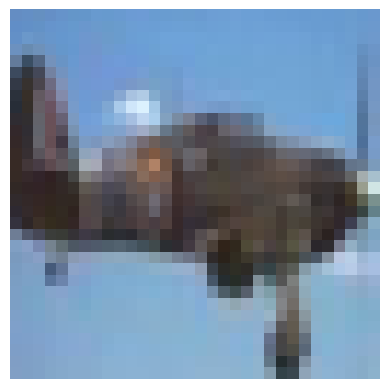

In [86]:
# transform = transforms.Compose([
#     transforms.ToTensor()
# ])


# class_names = [
#     "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
#     "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
# ]

# class_names = ["o", "ki", "su", "tsu", "na", "ha", "ma", "ya", "re", "wo"]

# transform = transforms.Compose([
#     transforms.Grayscale(num_output_channels=1), # Make it Black & White
#     transforms.Resize((28, 28)),                 # Shrink to MNIST size
#     transforms.ToTensor()
# ])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # values between -1 and 1
])

class_names = [
    "airplane", "automobile", "bird", "cat", "deer", 
    "dog", "frog", "horse", "ship", "truck"
]

# Download MNIST
full_train = datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

# Split: 50k train / 10k validation
train_size = 45_000
val_size = 5_000
unused_size = len(full_train) - train_size - val_size

train_dataset, val_dataset, _ = random_split(
    full_train, [train_size, val_size, unused_size]
)

# Dataloaders
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def get_calib_loader(num_samples=1000, batch_size=batch_size):
    indices = torch.randperm(len(train_dataset))[:num_samples]
    calib_dataset = Subset(train_dataset, indices)
    calib_loader = DataLoader(calib_dataset, batch_size=batch_size, shuffle=False)
    return calib_loader

calib_loader = get_calib_loader(100)
    

print("train size:", len(train_dataset))
print("val size:", len(val_dataset))
if unused_size > 0:
    print("unused_size:", unused_size)
print("test size:", len(test_dataset))
print("\nbatch size:", batch_size)

print("\nrandom sample sample:")
idx = random.randint(0, len(test_dataset) - 1)
img_tensor, label = test_dataset[idx]
img_tensor = img_tensor * 0.5 + 0.5  # denormalize
img_to_show = img_tensor.permute(1, 2, 0).numpy()
plt.imshow(img_to_show)
plt.axis("off")
plt.show()

## Model Definition
- The NN-Architecture does not change

In [4]:
class FP32(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False)  # bias=False because bn1 has its own bias
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        
        self.pool1  = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False)  # bias=False because bn1 has its own bias
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        
        self.pool2  = nn.MaxPool2d(2)

        # 64 channels and 32 / 2 / 2 = 8 (two pools)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

## Generic Training and Evaluation Methods

In [5]:
def train_one_epoch(model, loader, optimizer, criterion, epoch_num=1):
    model.train()  # just sets the mode :)
    total_loss = 0.0

    loader_with_tqdm = tqdm(loader, desc=f"Training Epoch {epoch_num}")
    loader_with_tqdm.total = len(loader)

    for x, y in loader_with_tqdm:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

In [6]:
@torch.no_grad()
def evaluate(net, loader):
    net.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    total_time = 0
    avg_time = 0

    # loader_with_tqdm = tqdm(enumerate(loader), desc=f"Evaluating Model")
    # loader_with_tqdm.total = len(loader)

    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        start = time.perf_counter()
        out = net(x)
        end = time.perf_counter()

        total_time += end - start
        avg_time += (end - start - avg_time) / (i + 1)
        
        loss = criterion(out, y)

        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    avg_time /= batch_size

    avg_latency_ms = avg_time * 1000
    throughput = 1 / avg_time
    acc = correct / total
    
    return total_loss / len(loader), acc, total_time, avg_latency_ms, throughput

In [7]:
def model_size_mb(model) -> float:
    with tempfile.NamedTemporaryFile(delete=False) as tmp:
        torch.save(model.state_dict(), tmp.name)
        size_mb = os.path.getsize(tmp.name) / (1024 ** 2)
    os.remove(tmp.name)
    return size_mb

In [8]:
def test(net, model_name="CNN"):
    test_loss, test_acc, total_time, latency, throughput = evaluate(net, test_loader)
    test_size = model_size_mb(net)

    print(f"-- Evaluating {model_name} --")
    print(f"{model_name} evaluation finished in {total_time:.4f}s")
    print(f"{model_name} Test Accuracy: {test_acc:.4f}")
    print(f"{model_name} Model Size: {test_size:.4f}MB")
    print(f"{model_name} Inference Latency: {latency:.4f}ms")
    print(f"{model_name} Inference Throughput per second: {throughput:.0f}")
    print()

In [9]:
def calculating_avg_latency(net, iterations=10):
    total_avg_lat = 0
    for _ in range(iterations):
        _, _, _, avg, _ = evaluate(net, test_loader)
        total_avg_lat += avg
    avg_latency_ms = total_avg_lat / iterations
    return avg_latency_ms

## Training
- Train once or load if exists (if already trained)

In [87]:
model_path = "./models/fp32.pth"

model = FP32().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20

val_accuracies = []
epoch_train_times = []

if os.path.exists(model_path):
    print("Loading trained FP32 model from disk...")
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))

else:
    print("Training FP32 model...")

    for epoch in range(num_epochs):
        
        start = time.time()
        _ = train_one_epoch(
            model, train_loader, optimizer, criterion, epoch_num=epoch+1
        )
        epoch_time = time.time() - start
        
        _, val_acc, _, _, _ = evaluate(
            model, val_loader
        )

        epoch_train_times.append(epoch_time)
        val_accuracies.append(val_acc)

        print(f"Trained Epoch {epoch+1} in {epoch_time} seconds with val_accuracy: {val_acc:.4f}")

    print("Training finished")

    total_training_time = sum(epoch_train_times)
    print(f"Total Time trained: {total_training_time}")
    print(f"Avg. Time per Epoch: {total_training_time / num_epochs}")
    
    torch.save(model.state_dict(), model_path)
    print("Model saved to:", model_path)

Training FP32 model...


Training Epoch 1: 100%|██████████████████████████████████████████████████████████████| 704/704 [00:26<00:00, 26.38it/s]


Trained Epoch 1 in 26.687149047851562 seconds with val_accuracy: 0.5936


Training Epoch 2: 100%|██████████████████████████████████████████████████████████████| 704/704 [00:27<00:00, 25.50it/s]


Trained Epoch 2 in 27.606303930282593 seconds with val_accuracy: 0.6824


Training Epoch 3: 100%|██████████████████████████████████████████████████████████████| 704/704 [00:26<00:00, 26.74it/s]


Trained Epoch 3 in 26.3345890045166 seconds with val_accuracy: 0.6748


Training Epoch 4: 100%|██████████████████████████████████████████████████████████████| 704/704 [00:26<00:00, 26.72it/s]


Trained Epoch 4 in 26.35403561592102 seconds with val_accuracy: 0.6990


Training Epoch 5: 100%|██████████████████████████████████████████████████████████████| 704/704 [00:26<00:00, 26.49it/s]


Trained Epoch 5 in 26.575404167175293 seconds with val_accuracy: 0.7080


Training Epoch 6: 100%|██████████████████████████████████████████████████████████████| 704/704 [00:26<00:00, 26.53it/s]


Trained Epoch 6 in 26.53761386871338 seconds with val_accuracy: 0.7222


Training Epoch 7: 100%|██████████████████████████████████████████████████████████████| 704/704 [00:26<00:00, 26.25it/s]


Trained Epoch 7 in 26.82417583465576 seconds with val_accuracy: 0.7250


Training Epoch 8: 100%|██████████████████████████████████████████████████████████████| 704/704 [00:26<00:00, 26.63it/s]


Trained Epoch 8 in 26.43712043762207 seconds with val_accuracy: 0.7216


Training Epoch 9: 100%|██████████████████████████████████████████████████████████████| 704/704 [00:27<00:00, 25.88it/s]


Trained Epoch 9 in 27.207009315490723 seconds with val_accuracy: 0.7208


Training Epoch 10: 100%|█████████████████████████████████████████████████████████████| 704/704 [00:29<00:00, 23.66it/s]


Trained Epoch 10 in 29.752137184143066 seconds with val_accuracy: 0.7166


Training Epoch 11: 100%|█████████████████████████████████████████████████████████████| 704/704 [00:29<00:00, 24.07it/s]


Trained Epoch 11 in 29.254241943359375 seconds with val_accuracy: 0.7288


Training Epoch 12: 100%|█████████████████████████████████████████████████████████████| 704/704 [00:28<00:00, 25.05it/s]


Trained Epoch 12 in 28.10904836654663 seconds with val_accuracy: 0.7198


Training Epoch 13: 100%|█████████████████████████████████████████████████████████████| 704/704 [00:28<00:00, 25.12it/s]


Trained Epoch 13 in 28.02737593650818 seconds with val_accuracy: 0.7156


Training Epoch 14: 100%|█████████████████████████████████████████████████████████████| 704/704 [00:27<00:00, 25.58it/s]


Trained Epoch 14 in 27.527302980422974 seconds with val_accuracy: 0.7252


Training Epoch 15: 100%|█████████████████████████████████████████████████████████████| 704/704 [00:27<00:00, 25.55it/s]


Trained Epoch 15 in 27.554075241088867 seconds with val_accuracy: 0.7222


Training Epoch 16: 100%|█████████████████████████████████████████████████████████████| 704/704 [00:28<00:00, 24.91it/s]


Trained Epoch 16 in 28.25969386100769 seconds with val_accuracy: 0.7158


Training Epoch 17: 100%|█████████████████████████████████████████████████████████████| 704/704 [00:27<00:00, 25.58it/s]


Trained Epoch 17 in 27.519160747528076 seconds with val_accuracy: 0.7250


Training Epoch 18: 100%|█████████████████████████████████████████████████████████████| 704/704 [00:27<00:00, 25.40it/s]


Trained Epoch 18 in 27.713924884796143 seconds with val_accuracy: 0.7226


Training Epoch 19: 100%|█████████████████████████████████████████████████████████████| 704/704 [00:28<00:00, 24.96it/s]


Trained Epoch 19 in 28.203318119049072 seconds with val_accuracy: 0.7128


Training Epoch 20: 100%|█████████████████████████████████████████████████████████████| 704/704 [00:28<00:00, 25.12it/s]


Trained Epoch 20 in 28.02607226371765 seconds with val_accuracy: 0.7176
Training finished
Total Time trained: 550.5097527503967
Avg. Time per Epoch: 27.525487637519838
Model saved to: ./models/fp32.pth


## Evaluation
- generic method

In [88]:
test(model, model_name="PTQ Naive")

-- Evaluating PTQ Naive --
PTQ Naive evaluation finished in 1.3901s
PTQ Naive Test Accuracy: 0.7191
PTQ Naive Model Size: 2.0857MB
PTQ Naive Inference Latency: 0.1383ms
PTQ Naive Inference Throughput per second: 7228



## Experiments

In [89]:
print(len(train_loader))
print(len(test_loader) * batch_size)

704
10048


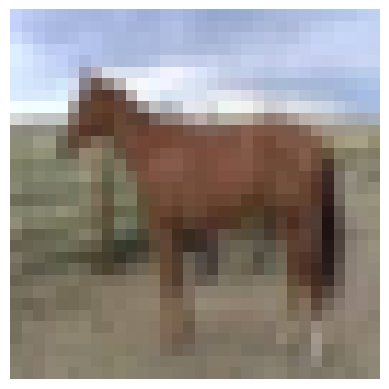

Actual Label: horse
Prediction:   horse
Result:       ✅ Correct


In [158]:
def visualize_prediction(model, dataset):
    idx = random.randint(0, len(dataset) - 1)
    img_tensor, label = dataset[idx]

    img_display = img_tensor.clone()
    img_display = img_display * 0.5 + 0.5  # denormalize
    img_display = img_display.permute(1, 2, 0).numpy()
    plt.imshow(img_display)
    plt.axis("off")
    plt.show()
    
    # Inference
    model.eval()
    input_batch = img_tensor.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_batch)
        prediction = output.argmax(dim=1).item()
    
    pred_name = class_names[prediction]
    gt_name   = class_names[label]

    print(f"Actual Label: {gt_name}")
    print(f"Prediction:   {pred_name}")
    
    if prediction == label:
        print("Result:       ✅ Correct")
    else:
        print("Result:       ❌ Incorrect")

visualize_prediction(model, test_dataset)

# PTQ (Naive)

In [106]:
class NaivePTQ(FP32):
    def __init__(self):
        super().__init__()
        self.quant = torch.quantization.QuantStub()  # introduces observers
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = super().forward(x)
        x = self.dequant(x)
        return x

In [107]:
net_ptq_naive = NaivePTQ().to(device)
net_ptq_naive.load_state_dict(model.state_dict())
net_ptq_naive.eval()

net_ptq_naive.qconfig = torch.ao.quantization.default_qconfig
net_ptq_naive = torch.ao.quantization.prepare(net_ptq_naive)  # insert observers for callibration / MinMaxObservers
net_ptq_naive

NaivePTQ(
  (conv1): Conv2d(
    3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (bn1): BatchNorm2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(
    32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (bn2): BatchNorm2d(
    64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(
    in_features=4096, out_features=128, bias=True
    (activation_post_process): MinMa

### Callibrate with evaluation

In [108]:
# calibration
evaluate(net_ptq_naive, calib_loader)

(0.1007937379181385,
 0.96,
 0.017298099934123456,
 0.1351414057353395,
 7399.65663786565)

In [109]:
# printing all observed min and max values
net_ptq_naive

NaivePTQ(
  (conv1): Conv2d(
    3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
    (activation_post_process): MinMaxObserver(min_val=-2.6395344734191895, max_val=2.47123122215271)
  )
  (bn1): BatchNorm2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (activation_post_process): MinMaxObserver(min_val=-9.967764854431152, max_val=10.926153182983398)
  )
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(
    32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
    (activation_post_process): MinMaxObserver(min_val=-34.853912353515625, max_val=19.176321029663086)
  )
  (bn2): BatchNorm2d(
    64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (activation_post_process): MinMaxObserver(min_val=-12.930061340332031, max_val=9.227407455444336)
  )
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil

In [110]:
# actual quantization:
net_ptq_naive = torch.ao.quantization.convert(net_ptq_naive)
net_ptq_naive

NaivePTQ(
  (conv1): QuantizedConv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.04024224728345871, zero_point=66, padding=(1, 1), bias=False)
  (bn1): QuantizedBatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): QuantizedConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.4254349172115326, zero_point=82, padding=(1, 1), bias=False)
  (bn2): QuantizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): QuantizedLinear(in_features=4096, out_features=128, scale=1.00246262550354, zero_point=91, qscheme=torch.per_tensor_affine)
  (relu3): ReLU()
  (fc2): QuantizedLinear(in_features=128, out_features=10, scale=0.6121195554733276, zero_point=72, qscheme=torch.per_tensor_affine)
  (quant): Quantize(scal

this results in assymatric quantization: Each layer has a scale and a zero_point to quantized the values

### Compare weights with baseline

In [111]:
print(f"Weights of FT32 baseline:")
print(model.conv1.weight[0])
print("\n")
print(f"Quantized Weights of naive_ptq:")
print(torch.int_repr(net_ptq_naive.conv1.weight()[0]))
print("\n")
print(f"Dequantized Weights of naive_ptq:")
print(torch.dequantize(net_ptq_naive.conv1.weight()[0]))

Weights of FT32 baseline:
tensor([[[ 0.0976,  0.0690, -0.2166],
         [ 0.0373,  0.2020, -0.2204],
         [ 0.2167,  0.1306, -0.2251]],

        [[ 0.1631, -0.0960, -0.0245],
         [ 0.1097, -0.1493,  0.0405],
         [-0.1509, -0.2385,  0.0964]],

        [[-0.2127, -0.0397,  0.2688],
         [-0.1420, -0.1849,  0.2435],
         [-0.0736,  0.0536,  0.1556]]], grad_fn=<SelectBackward0>)


Quantized Weights of naive_ptq:
tensor([[[ 16,  11, -36],
         [  6,  33, -36],
         [ 36,  21, -37]],

        [[ 27, -16,  -4],
         [ 18, -24,   7],
         [-25, -39,  16]],

        [[-35,  -7,  44],
         [-23, -30,  40],
         [-12,   9,  26]]], dtype=torch.int8)


Dequantized Weights of naive_ptq:
tensor([[[ 0.0976,  0.0671, -0.2195],
         [ 0.0366,  0.2013, -0.2195],
         [ 0.2195,  0.1281, -0.2256]],

        [[ 0.1647, -0.0976, -0.0244],
         [ 0.1098, -0.1464,  0.0427],
         [-0.1525, -0.2378,  0.0976]],

        [[-0.2134, -0.0427,  0.2683],
 

### Evaluate PTQNaive

In [112]:
test(net_ptq_naive, model_name="PTQ Naive")

-- Evaluating PTQ Naive --
PTQ Naive evaluation finished in 0.4887s
PTQ Naive Test Accuracy: 0.7142
PTQ Naive Model Size: 0.5307MB
PTQ Naive Inference Latency: 0.0486ms
PTQ Naive Inference Throughput per second: 20562



# PTQ + Bias Correction

- Bias Correction operates layer-wise
- After PTQ a layer computes:
$$
y_q=W_qx_q+b
$$
- The Idea for Bias Correction:
$$
\mathbb{E}[W_qx_q]\neq\mathbb{E}[Wx]
$$
- fix in bias $b$ of NN:
$$
b'=b+\mathbb{E}[Wx]-\mathbb{E}[W_qx_q]
$$
- new output:
$$
y_q=W_qx_q+b'
$$

In [113]:
def collect_layer_outputs(net, loader, layers):
    outputs = {name: [] for name in layers}

    hooks = []

    def make_hook(name):
        def hook(module, inp, out):
            outputs[name].append(out.detach().cpu())
        return hook

    for name, module in net.named_modules():
        if name in layers:
            hooks.append(module.register_forward_hook(make_hook(name)))

    model.eval()
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            net(x)

    for h in hooks:
        h.remove()

    return {k: torch.cat(v, dim=0) for k, v in outputs.items()}

In [114]:
def bias_correction_pre_convert(fp32_model, prepared_model, calib_loader):
    layers = [
        name for name, m in fp32_model.named_modules()
        if isinstance(m, (nn.Conv2d, nn.Linear)) and m.bias is not None
    ]

    fp32_outs = collect_layer_outputs(fp32_model, calib_loader, layers)
    prep_outs = collect_layer_outputs(prepared_model, calib_loader, layers)

    for name in layers:
        fp32 = fp32_outs[name]
        prep = prep_outs[name]

        if fp32.dim() == 4:   # Conv
            delta = (fp32 - prep).mean(dim=(0, 2, 3))
        else:                 # Linear
            delta = (fp32 - prep).mean(dim=0)

        module = dict(prepared_model.named_modules())[name]
        module.bias.data += delta.to(module.bias.device)

    return prepared_model

In [115]:
net_bias = NaivePTQ().to(device)
net_bias.load_state_dict(model.state_dict())
net_bias.eval()

net_bias.qconfig = torch.ao.quantization.default_qconfig
torch.ao.quantization.prepare(net_bias, inplace=True)

NaivePTQ(
  (conv1): Conv2d(
    3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (bn1): BatchNorm2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(
    32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (bn2): BatchNorm2d(
    64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(
    in_features=4096, out_features=128, bias=True
    (activation_post_process): MinMa

In [116]:
fp32_ref = FP32().to(device)
fp32_ref.load_state_dict(model.state_dict())
fp32_ref.eval()

FP32(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [117]:
net_bias = bias_correction_pre_convert(
    fp32_ref,
    net_bias,
    calib_loader
)

net_bias = torch.ao.quantization.convert(net_bias)

In [118]:
test(net_bias, model_name="PTQ with Bias Correction")

-- Evaluating PTQ with Bias Correction --
PTQ with Bias Correction evaluation finished in 0.4729s
PTQ with Bias Correction Test Accuracy: 0.7142
PTQ with Bias Correction Model Size: 0.5307MB
PTQ with Bias Correction Inference Latency: 0.0471ms
PTQ with Bias Correction Inference Throughput per second: 21248



# PTQ + BN Folding

In [119]:
class PTQ_BN_Folding(FP32):
    def __init__(self):
        super().__init__()
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = super().forward(x)  # (Fusion will replace conv1+bn1+relu1 with a single ConvReLU module / same with conv2+bn2+relu2)
        x = self.dequant(x)
        return x

In [120]:
# Load weights from the trained BN model
net_ptq_fold = PTQ_BN_Folding().to(device)
net_ptq_fold.load_state_dict(model.state_dict())
net_ptq_fold.eval()

PTQ_BN_Folding(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (quant): QuantStub()
  (dequant): DeQuantStub()
)

In [121]:
# Fusing Conv2d + BatchNorm2d + ReLU
torch.ao.quantization.fuse_modules(
    net_ptq_fold, 
    [['conv1', 'bn1', 'relu1'], ['conv2', 'bn2', 'relu2']], 
    inplace=True
)

PTQ_BN_Folding(
  (conv1): ConvReLU2d(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (bn1): Identity()
  (relu1): Identity()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): ConvReLU2d(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (bn2): Identity()
  (relu2): Identity()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (quant): QuantStub()
  (dequant): DeQuantStub()
)

In [122]:
# Prepare (Insert Observers)
net_ptq_fold.qconfig = torch.ao.quantization.default_qconfig
torch.ao.quantization.prepare(net_ptq_fold, inplace=True)

PTQ_BN_Folding(
  (conv1): ConvReLU2d(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (bn1): Identity()
  (relu1): Identity()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): ConvReLU2d(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (bn2): Identity()
  (relu2): Identity()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(
    in_features=4096, out_features=128, bias=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (relu3): ReLU()
  (fc2): Linear(
    in_features=128, out_features=10, bias=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (quant): QuantStub(
    (activation_post_

In [123]:
# Calibrate
evaluate(net_ptq_fold, calib_loader)

(0.1007937453687191,
 0.96,
 0.014840999967418611,
 0.1159453122454579,
 8624.755763156561)

In [124]:
# actual quantization
torch.ao.quantization.convert(net_ptq_fold, inplace=True)

PTQ_BN_Folding(
  (conv1): QuantizedConvReLU2d(3, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.0860326960682869, zero_point=0, padding=(1, 1))
  (bn1): Identity()
  (relu1): Identity()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): QuantizedConvReLU2d(32, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.07265675067901611, zero_point=0, padding=(1, 1))
  (bn2): Identity()
  (relu2): Identity()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): QuantizedLinear(in_features=4096, out_features=128, scale=1.0024625062942505, zero_point=91, qscheme=torch.per_tensor_affine)
  (relu3): ReLU()
  (fc2): QuantizedLinear(in_features=128, out_features=10, scale=0.6121194362640381, zero_point=72, qscheme=torch.per_tensor_affine)
  (quant): Quantize(scale=tensor([0.0157]), zero_point=tensor([64]), dtype=torch.quint8)
  (dequant): DeQuantize()
)

In [125]:
# Evaluate
test(net_ptq_fold, model_name="PTQ with BN Folding")

-- Evaluating PTQ with BN Folding --
PTQ with BN Folding evaluation finished in 0.4084s
PTQ with BN Folding Test Accuracy: 0.7149
PTQ with BN Folding Model Size: 0.5265MB
PTQ with BN Folding Inference Latency: 0.0406ms
PTQ with BN Folding Inference Throughput per second: 24605



# Mixed Precision PTQ 

## Calculate Layerwise Error / Sensitivity

In [126]:
def get_layer_sensitivity(fp32_model, quantized_model, loader, num_batches=None):
    fp32_model.eval()
    quantized_model.eval()
    
    total_squared_errors = {} 
    total_counts = {}
    
    # temp - cleaned after every batch
    batch_fp32_out = {}
    batch_quant_out = {}
    
    target_prefixes = ("conv", "fc")

    def make_hook(storage_dict, layer_name):
        def hook(module, inp, out):
            if hasattr(out, "is_quantized") and out.is_quantized:
                out = out.dequantize()
            storage_dict[layer_name] = out.detach().cpu()
        return hook

    handles = []
    
    for name, mod in fp32_model.named_modules():
        if name.startswith(target_prefixes):
            handles.append(mod.register_forward_hook(make_hook(batch_fp32_out, name)))
            
    for name, mod in quantized_model.named_modules():
        if name.startswith(target_prefixes):
            handles.append(mod.register_forward_hook(make_hook(batch_quant_out, name)))
    
    with torch.no_grad():
        for i, (x, _) in enumerate(loader):
            if num_batches and i >= num_batches:
                break
                
            x = x.to(device)
            
            batch_fp32_out.clear()
            batch_quant_out.clear()
            
            fp32_model(x)
            quantized_model(x)
            
            for name in batch_fp32_out.keys():
                if name in batch_quant_out:
                    out_f = batch_fp32_out[name]  # tensor
                    out_q = batch_quant_out[name]
                    
                    batch_squared_error = (out_f - out_q).pow(2).sum().item()
                    batch_count = out_f.numel()
                    
                    total_squared_errors[name] = total_squared_errors.get(name, 0.0) + batch_squared_error
                    total_counts[name] = total_counts.get(name, 0) + batch_count

    for h in handles:
        h.remove()

    final_sensitivity = {}
    for name in total_squared_errors:
        final_sensitivity[name] = total_squared_errors[name] / total_counts[name]

    return final_sensitivity

Starting robust sensitivity analysis...

Layer-wise MSE Error (Averaged over batches):
conv2: 5.818714
conv1: 0.210803
fc2: 0.177673
fc1: 0.105543


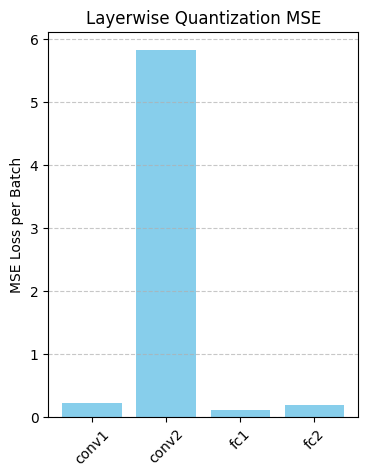

In [211]:
print("Starting robust sensitivity analysis...")
sensitivity = get_layer_sensitivity(
    model, 
    net_ptq_fold, 
    val_loader,
    num_batches=20
)

print("\nLayer-wise MSE Error (Averaged over batches):")
sorted_layers = sorted(sensitivity.items(), key=lambda item: item[1], reverse=True)
for name, score in sorted_layers:
    print(f"{name}: {score:.6f}")

# Plot
plt.figure(figsize=(4, 5))
plt.bar(sensitivity.keys(), sensitivity.values(), color='skyblue')
plt.title("Layerwise Quantization MSE")
plt.ylabel("MSE Loss per Batch")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("export/layerwise_error.png", dpi=300, bbox_inches='tight')
plt.show()

### Quantization of specific layers

In [159]:
class PTQ_Mixed_Precision(FP32):
    def __init__(self):
        super().__init__()
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()
        
        # convert back to FP32 for sensitive layer (conv2)
        self.mid_dequant = torch.quantization.DeQuantStub()
        # quantize again for last couple of layers
        self.mid_quant = torch.quantization.QuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        # exiting quantization
        x = self.mid_dequant(x) # Int8 -> FP32
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.mid_quant(x)  # FP32 -> Int8
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        
        x = self.dequant(x)
        return x

In [161]:
net_mixed = PTQ_Mixed_Precision().to(device)
net_mixed.load_state_dict(model.state_dict())
net_mixed.eval()

PTQ_Mixed_Precision(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (quant): QuantStub()
  (dequant): DeQuantStub()
  (mid_dequant): DeQuantStub()
  (mid_quant): QuantStub()
)

In [163]:
net_mixed.qconfig = torch.ao.quantization.default_qconfig
net_mixed.conv2.qconfig = None
net_mixed.bn2.qconfig = None
net_mixed.relu2.qconfig = None

In [164]:
torch.ao.quantization.prepare(net_mixed, inplace=True)

PTQ_Mixed_Precision(
  (conv1): Conv2d(
    3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (bn1): BatchNorm2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(
    in_features=4096, out_features=128, bias=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (relu3): ReLU()
  (fc2): Linear(
    in_features=128, out_features=10, bias=True
    (activation_post_proces

In [166]:
# calibration
evaluate(net_mixed, calib_loader)

(0.1007937379181385,
 0.96,
 0.014800099888816476,
 0.11562578038137872,
 8648.590277199528)

In [168]:
torch.ao.quantization.convert(net_mixed, inplace=True)

PTQ_Mixed_Precision(
  (conv1): QuantizedConv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.04024224728345871, zero_point=66, padding=(1, 1), bias=False)
  (bn1): QuantizedBatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): QuantizedLinear(in_features=4096, out_features=128, scale=1.00246262550354, zero_point=91, qscheme=torch.per_tensor_affine)
  (relu3): ReLU()
  (fc2): QuantizedLinear(in_features=128, out_features=10, scale=0.6121195554733276, zero_point=72, qscheme=torch.per_tensor_affine)
  (quant): Quantize(scale=tensor([0.0157]), zero_point=tensor([64]), dty

In [169]:
test(net_mixed, model_name="Mixed Precision Quantization")

-- Evaluating Mixed Precision Quantization --
Mixed Precision Quantization evaluation finished in 0.7217s
Mixed Precision Quantization Test Accuracy: 0.7146
Mixed Precision Quantization Model Size: 0.5829MB
Mixed Precision Quantization Inference Latency: 0.0718ms
Mixed Precision Quantization Inference Throughput per second: 13923



# QAT

# Final Evaluation

In [170]:
test(model, model_name="FP32 Baseline")
test(net_ptq_naive, model_name="PTQ Naive")
test(net_bias, model_name="PTQ with Bias Correction")
test(net_ptq_fold, model_name="PTQ with BN Folding")
test(net_mixed, model_name="Mixed Precision Quantization")

-- Evaluating FP32 Baseline --
FP32 Baseline evaluation finished in 1.4108s
FP32 Baseline Test Accuracy: 0.7191
FP32 Baseline Model Size: 2.0857MB
FP32 Baseline Inference Latency: 0.1404ms
FP32 Baseline Inference Throughput per second: 7122

-- Evaluating PTQ Naive --
PTQ Naive evaluation finished in 0.4727s
PTQ Naive Test Accuracy: 0.7142
PTQ Naive Model Size: 0.5307MB
PTQ Naive Inference Latency: 0.0470ms
PTQ Naive Inference Throughput per second: 21257

-- Evaluating PTQ with Bias Correction --
PTQ with Bias Correction evaluation finished in 0.4701s
PTQ with Bias Correction Test Accuracy: 0.7142
PTQ with Bias Correction Model Size: 0.5307MB
PTQ with Bias Correction Inference Latency: 0.0468ms
PTQ with Bias Correction Inference Throughput per second: 21373

-- Evaluating PTQ with BN Folding --
PTQ with BN Folding evaluation finished in 0.4051s
PTQ with BN Folding Test Accuracy: 0.7149
PTQ with BN Folding Model Size: 0.5265MB
PTQ with BN Folding Inference Latency: 0.0403ms
PTQ with BN

In [171]:
print(f"FP32 latency: {calculating_avg_latency(model):.4f}ms")
print(f"PTQ Naive latency: {calculating_avg_latency(net_ptq_naive):.4f}ms")
print(f"PTQ Bias Correction latency: {calculating_avg_latency(net_bias):.4f}ms")
print(f"PTQ BN Folding latency: {calculating_avg_latency(net_ptq_fold):.4f}ms")
print(f"Mixed Precision Quantization latency: {calculating_avg_latency(net_mixed):.4f}ms")

FP32 latency: 0.1412ms
PTQ Naive latency: 0.0483ms
PTQ Bias Correction latency: 0.0471ms
PTQ BN Folding latency: 0.0413ms
Mixed Precision Quantization latency: 0.0667ms


## Diagrams

In [182]:
models = ['FP32 Baseline', 'PTQ Naive', 'Bias Corr', 'BN Folding', 'Mixed Precision']
acc = [71.91, 71.42, 71.42, 71.49, 71.46]
size = [2.0857, 0.5307, 0.5307, 0.5265, 0.5829]
latency = [0.1412, 0.0483, 0.0471, 0.0413, 0.0667]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

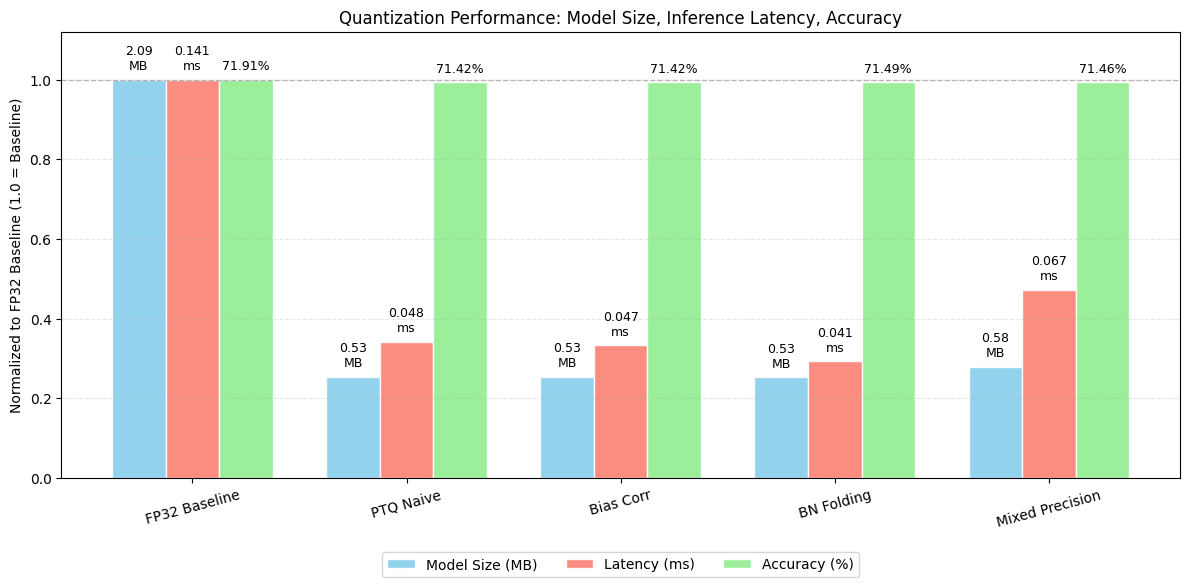

In [205]:
def plot_normalized_metrics():
    # normalizing everything to fp32 baseline
    norm_size = [s / size[0] for s in size]
    norm_lat = [l / latency[0] for l in latency]
    norm_acc = [a / acc[0] for a in acc]

    x = np.arange(len(models))
    width = 0.25

    fig, ax = plt.subplots(figsize=(12, 6))

    # bars
    rects_size = ax.bar(x - width, norm_size, width, label='Model Size (MB)', color='skyblue', alpha=0.9, edgecolor='white')
    rects_lat = ax.bar(x, norm_lat, width, label='Latency (ms)', color='salmon', alpha=0.9, edgecolor='white')
    rects_acc = ax.bar(x + width, norm_acc, width, label='Accuracy (%)', color='lightgreen', alpha=0.9, edgecolor='white')

    # ax ui (labels etc.)
    ax.set_ylabel('Normalized to FP32 Baseline (1.0 = Baseline)')
    ax.set_title('Quantization Performance: Model Size, Inference Latency, Accuracy')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=15)
    ax.set_ylim(0, 1.12)

    ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    # adding labels above each bar
    def autolabel(rects, original_values, unit_suffix=""):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            val = original_values[i]
            
            # Format text based on unit
            if unit_suffix == "MB":
                label_text = f"{val:.2f}\nMB"
            elif unit_suffix == "ms":
                label_text = f"{val:.3f}\nms"
            else:
                label_text = f"{val:.2f}%"

            ax.annotate(label_text,
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

    autolabel(rects_size, size, "MB")
    autolabel(rects_lat, latency, "ms")
    autolabel(rects_acc, acc, "%")

    plt.savefig('export/quantization_performance_bars.png', dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

plot_normalized_metrics()

Diagram saved to export/pareto_frontier.png


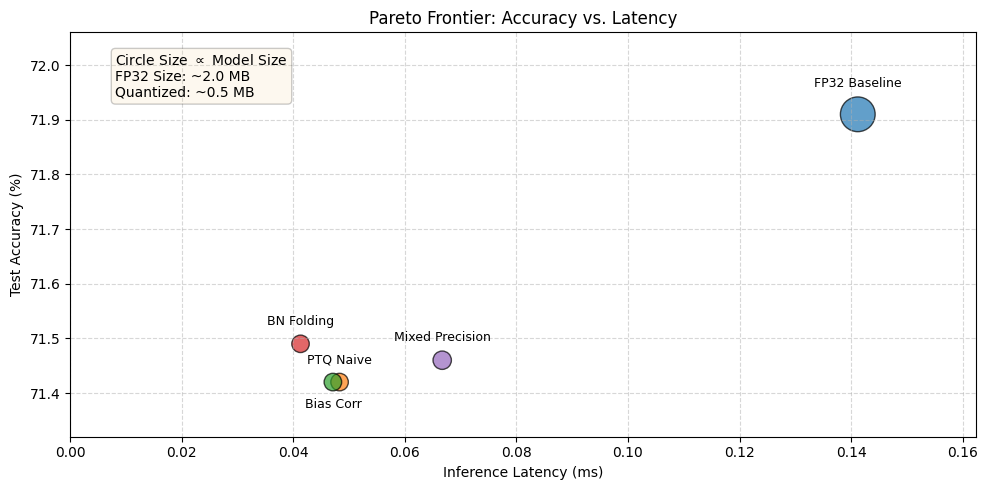

In [215]:
def plot_pareto_frontier():
    fig, ax = plt.subplots(figsize=(10, 5))

    bubble_areas = [s * 300 for s in size]
    
    scatter = ax.scatter(latency, acc, s=bubble_areas, c=colors, alpha=0.7, edgecolors='black')

    for i, txt in enumerate(models):
        radius = np.sqrt(bubble_areas[i]) / 2
        offset = radius + 5
        
        xy_coords = (0, offset)
        vert_align = 'bottom'
        
        # bias corr needs to go below point to not overlap with naive ptq
        if txt == 'Bias Corr':
            xy_coords = (0, -offset)
            vert_align = 'top'
            
        ax.annotate(txt, (latency[i], acc[i]), 
                    xytext=xy_coords, textcoords='offset points', 
                    ha='center', va=vert_align, fontsize=9)

    ax.set_xlabel('Inference Latency (ms)')
    ax.set_ylabel('Test Accuracy (%)')
    ax.set_title('Pareto Frontier: Accuracy vs. Latency')
    
    ax.set_ylim(min(acc) - 0.1, max(acc) + 0.15)
    ax.set_xlim(left=0, right=max(latency) * 1.15)

    ax.grid(True, linestyle='--', alpha=0.5)

    textstr = '\n'.join((
        r'Circle Size $\propto$ Model Size',
        r'FP32 Size: ~2.0 MB',
        r'Quantized: ~0.5 MB'))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.2)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

    plt.tight_layout()
    
    plt.savefig('export/pareto_frontier.png', dpi=300, bbox_inches='tight')
    
    print("Diagram saved to export/pareto_frontier.png")
    plt.show()

plot_pareto_frontier()

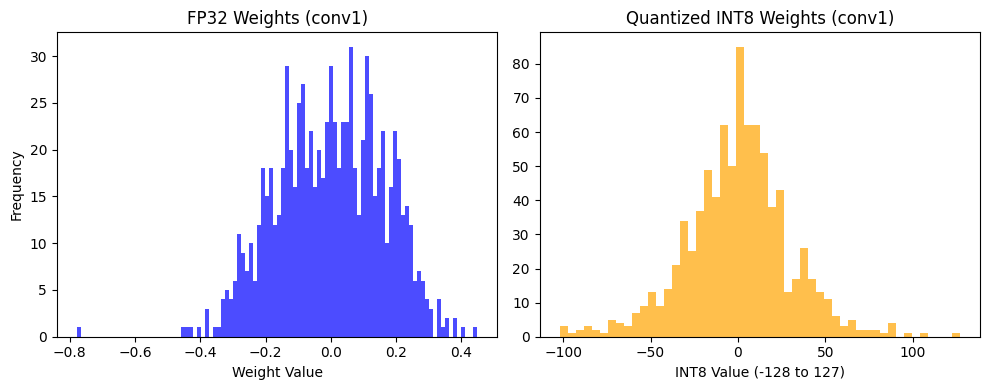

In [220]:
# this diagram was almost entirely generated using google gemini
def plot_weight_distribution(fp32_model, quant_model, layer_name='conv1'):
    fp32_weights = fp32_model.state_dict()[f'{layer_name}.weight'].flatten().cpu().numpy()
    
    if hasattr(quant_model, layer_name):
        q_layer = getattr(quant_model, layer_name)
        if hasattr(q_layer, '0'): 
            q_layer = q_layer[0]
            
        if hasattr(q_layer, 'weight'):
            q_weights = q_layer.weight().int_repr().flatten().cpu().numpy()
            scale = q_layer.scale
            zero_point = q_layer.zero_point
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    ax1.hist(fp32_weights, bins=100, color='blue', alpha=0.7)
    ax1.set_title(f'FP32 Weights ({layer_name})')
    ax1.set_xlabel('Weight Value')
    ax1.set_ylabel('Frequency')
    
    ax2.hist(q_weights, bins=50, color='orange', alpha=0.7)
    ax2.set_title(f'Quantized INT8 Weights ({layer_name})')
    ax2.set_xlabel('INT8 Value (-128 to 127)')
    
    plt.tight_layout()
    plt.show()

plot_weight_distribution(model, net_ptq_fold, layer_name='conv1')

Analyzing per-class accuracy...
Largest Drop: 'deer' lost 2.0% accuracy


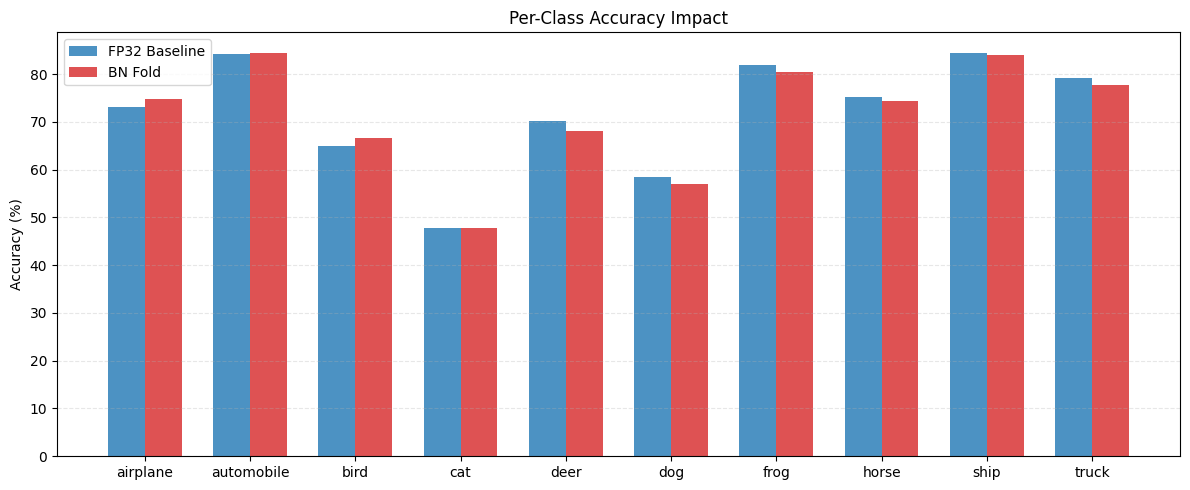

In [222]:
# this diagram was almost entirely generated using google gemini
def plot_per_class_comparison(fp32_model, quant_model, loader):
    stats = {c: [0, 0, 0] for c in class_names}
    
    fp32_model.eval()
    quant_model.eval()
    
    print("Analyzing per-class accuracy...")
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            
            out_fp = fp32_model(x).argmax(1)
            out_q = quant_model(x).argmax(1)
            
            for i in range(len(y)):
                label = class_names[y[i].item()]
                stats[label][0] += 1
                
                if out_fp[i] == y[i]:
                    stats[label][1] += 1
                if out_q[i] == y[i]:
                    stats[label][2] += 1

    labels = list(stats.keys())
    acc_fp = [s[1]/s[0] * 100 for s in stats.values()]
    acc_q  = [s[2]/s[0] * 100 for s in stats.values()]
    
    x = np.arange(len(labels))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 5))
    
    ax.bar(x - width/2, acc_fp, width, label='FP32 Baseline', color='#1f77b4', alpha=0.8)
    ax.bar(x + width/2, acc_q, width, label='BN Fold', color='#d62728', alpha=0.8)
    
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Per-Class Accuracy Impact')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    drops = [f - q for f, q in zip(acc_fp, acc_q)]
    max_drop_idx = np.argmax(drops)
    print(f"Largest Drop: '{labels[max_drop_idx]}' lost {drops[max_drop_idx]:.1f}% accuracy")

    plt.tight_layout()
    plt.savefig('export/per_class_accuracy.png', bbox_inches='tight')
    plt.show()

plot_per_class_comparison(model, net_ptq_fold, test_loader)

- interesting to see that in smoe categories the quantized version even performs better
- probabl because the baseline is overfitting